# Семинар 2: Свертка изображений

## Вступление
На ближайших семинарах мы научимся решать некоторые задачи компьютерного зрения при помощи нейронных сетей. Основной инструмент работы в этой области — свёртки. С ними мы сегодня и познакомимся.

### План семинара
1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**
2. Применяем константные свёртки к изображениям
3. Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**

### Загружаем изображение с диска

In [2]:
# при работе в колабе, скачайте изображение этой командой
# !wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

Image format: JPEG; shape: (640, 427); color scheme: RGB


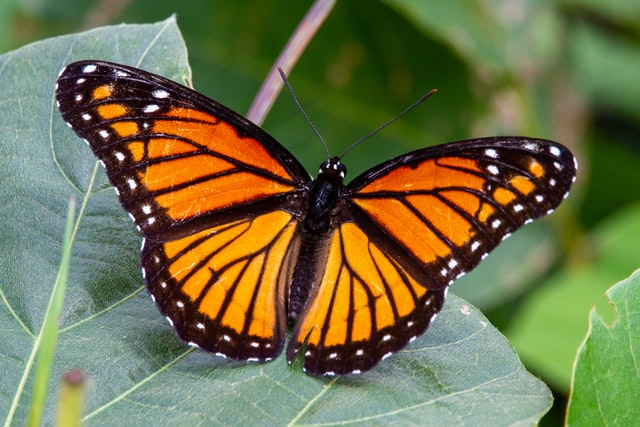

In [3]:
# !pip install Pillow
from PIL import Image

img = Image.open("static/butterfly.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

### Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

Image array shape: (427, 640, 3)


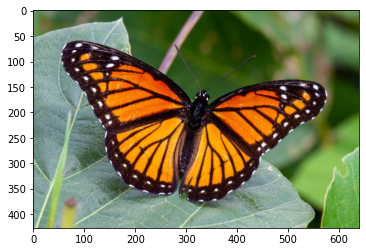

In [4]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.show()

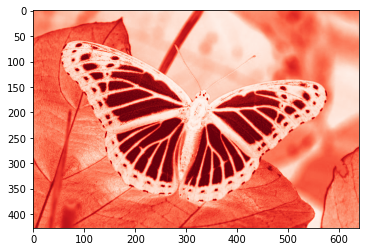

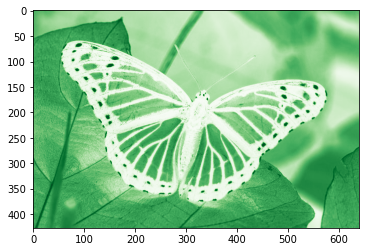

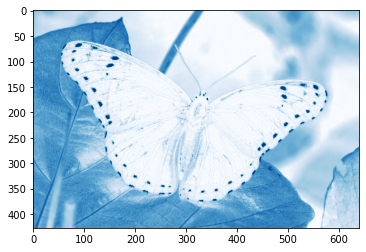

In [5]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

## 2. Применяем константные свёртки к изображениям

### Класс torch.nn.Conv2d
В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- растяжение `dilation`

___
**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**kernel_size=3**

![no_padding_no_strides.gif](static/no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic).

___
**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**stride=2**

![no_padding_strides.gif](static/no_padding_strides.gif)


___
**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**padding="half"**

![same_padding_no_strides.gif](static/same_padding_no_strides.gif)

### Свёртка изображений
Применим оператор Собеля для детектирования границ на изображении. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`. В этом модуле примерно все те же самые операторы, что и в `torch.nn`, но только представлениы они не в виде классов, а виде функций.

In [6]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [7]:
img_matrix.shape

(427, 640, 3)

In [8]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [9]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [10]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 425, 638, 1])

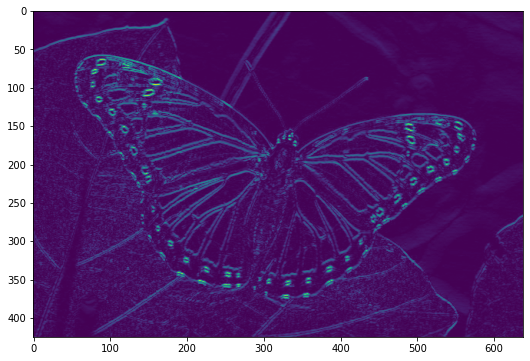

In [11]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Проделаем то же самое для детектирования вертикальных границ

In [12]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 425, 638, 1])

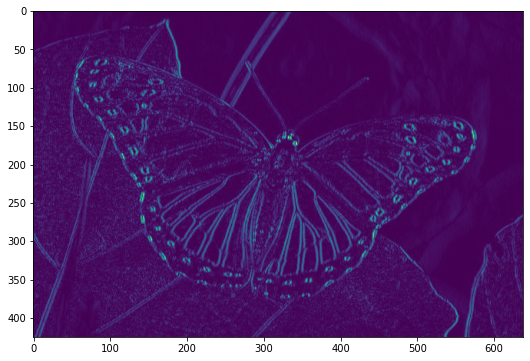

In [13]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

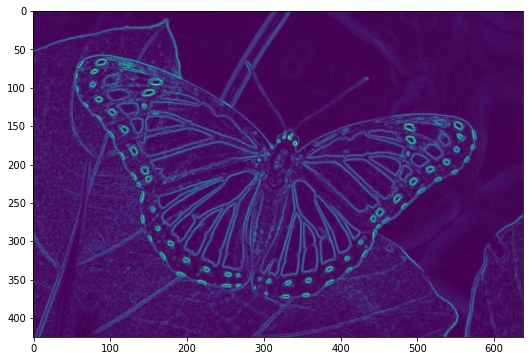

In [14]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

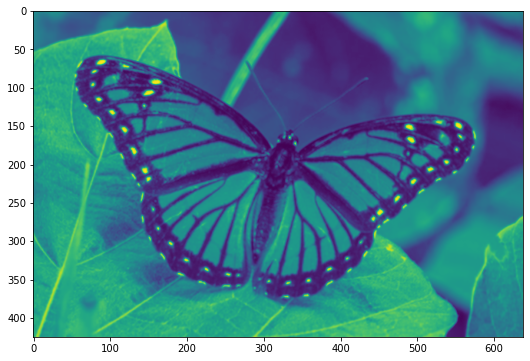

In [15]:
### YOUR CODE HERE
kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

### Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST

Сначала решим задачу классификации изображений полносвязной нейронной сетью из прошлого семинара.

In [16]:
import torch.nn.functional as F
import torchvision
from torch import nn

Скачаем и подготовим уже знакомые нам данные для классификации.

In [17]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=transform
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=transform
)


train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

Подготовим цикл обучения.

In [18]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            # печатаем метрики
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

Обучим полносвязную архитектуру.

In [19]:
model = nn.Sequential(
    nn.Flatten(),             # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                # нелинейность
    nn.Linear(128, 10),       # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [20]:
print(f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters")
train(model, optimizer)

Training model with 101770 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.32149407267570496, accuracy: 0.9083


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2338201254606247, accuracy: 0.9323


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.18939584493637085, accuracy: 0.9443


Изменим архитектуру, добавив в неё свёрточные слои.

In [21]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим свёрточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),                 # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128),       # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),                    # нелинейность
    nn.Linear(128, 10),           # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [22]:
print(f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters")
train(model, optimizer)

Training model with 47758 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.20540378987789154, accuracy: 0.9384


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.10352662205696106, accuracy: 0.9685


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.07800120115280151, accuracy: 0.9761


### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой будут следующие слои:

- Свёрточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

Сделайте решение с моделью в виде класса, отнаследованного от `torch.nn.Module`.

In [23]:
### YOUR CODE HERE
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),   # добавим свёрточный слой с 10 ядрами
    nn.ReLU(),                                                  # нелинейность
    nn.MaxPool2d(kernel_size=2),                                # уменьшим картинку в 2 раза
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),  # добавим свёрточный слой с 20 ядрами
    nn.ReLU(),                    # нелинейность
    nn.MaxPool2d(kernel_size=2),  # уменьшим картинку в 2 раза
    nn.Flatten(),                 # превращаем картинку 4х4х20 в вектор размером 320
    nn.Linear(4*4*20, 128),       # линейный слой, преобразующий вектор размера 320 в вектор размера 128
    nn.ReLU(),                    # нелинейность
    nn.Linear(128, 10),           # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.21043570339679718, accuracy: 0.936


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08918825536966324, accuracy: 0.9722


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.09426606446504593, accuracy: 0.9683
